In [1]:
%pip install torch numpy transformers datasets gensim

Note: you may need to restart the kernel to use updated packages.


## Part I

Download the dataset from HuggingFace

In [2]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 609.58it/s]


In [3]:
dataset.set_format("torch")
dataset.column_names

{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [4]:
import torch
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': tensor([22, 42, 16, 21, 35, 37, 16, 21,  7]),
 'chunk_tags': tensor([11, 21, 11, 12, 21, 22, 11, 12,  0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [5]:
from datasets import load_dataset

dataset = load_dataset("conll2003")
dataset.set_format("torch", columns=["tokens", "ner_tags"])
dataset.column_names

Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 914.72it/s]


{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [6]:
dataset['train'][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

### EDA

In [7]:
# create a word count dictionary from training data
word_list = []
for row in dataset['train']:
    word_list.extend(row['tokens'])
from collections import Counter
import numpy as np
counter = Counter(np.array(word_list))
counter

Counter({'EU': 24,
         'rejects': 1,
         'German': 85,
         'call': 30,
         'to': 3382,
         'boycott': 5,
         'British': 93,
         'lamb': 3,
         '.': 7374,
         'Peter': 31,
         'Blackburn': 11,
         'BRUSSELS': 17,
         '1996-08-22': 125,
         'The': 1127,
         'European': 86,
         'Commission': 49,
         'said': 1846,
         'on': 2040,
         'Thursday': 285,
         'it': 553,
         'disagreed': 2,
         'with': 840,
         'advice': 5,
         'consumers': 9,
         'shun': 1,
         'until': 53,
         'scientists': 6,
         'determine': 11,
         'whether': 45,
         'mad': 13,
         'cow': 12,
         'disease': 35,
         'can': 71,
         'be': 525,
         'transmitted': 2,
         'sheep': 12,
         'Germany': 143,
         "'s": 1536,
         'representative': 7,
         'the': 7243,
         'Union': 46,
         'veterinary': 8,
         'committee': 22,
    

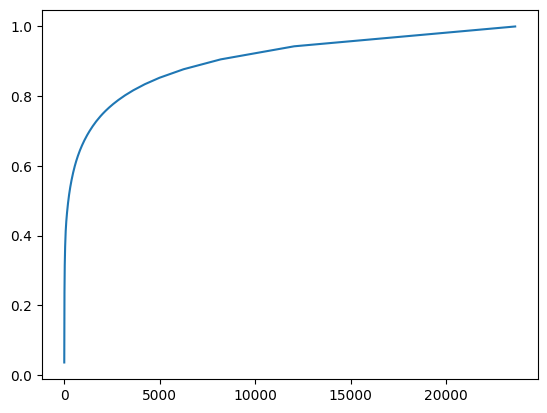

In [8]:
# sort counts by descending order and create a histogram of word covrege
counts = np.array(list(counter.values()))
counts = np.sort(counts)[::-1]
total_words = counts.sum()
counts = np.cumsum(counts)/total_words
from matplotlib import pyplot as plt
plt.plot(counts)
plt.show()

### Dataset

In [9]:
# choose 20000 most common words and create two way dictionaries
elements = counter.most_common(20000)
words_to_ids = {e[0]:i for e, i in zip(elements, range(len(elements)))}
words_to_ids['<UNK>'] = len(words_to_ids)
ids_to_words = {v:k for k, v in words_to_ids.items()}

In [10]:
import torch
convert_item = lambda x: { 'tokens': [words_to_ids.get(w, words_to_ids['<UNK>']) for w in x['tokens']] }
convert_item(dataset['train'][0])

{'tokens': [956, 11982, 232, 761, 5, 4146, 208, 6181, 0]}

In [11]:
# convert dataset to ids
for name in ['train', 'validation', 'test']:
    dataset[name] = dataset[name].map(convert_item, batched=False)

Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-dd796fdc36945aad.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-40cb9ee1eec1d9d0.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-8d8b0dcd70f1d28d.arrow


In [12]:
dataset['train'][0]

{'tokens': tensor([  956, 11982,   232,   761,     5,  4146,   208,  6181,     0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [13]:
from torch.nn.utils.rnn import pack_sequence
def collate_fn(batch):
    tokens = pack_sequence([ exmp['tokens'] for exmp in batch ], enforce_sorted=False)
    ner_tags = pack_sequence([ exmp['ner_tags'] for exmp in batch ], enforce_sorted=False)
    return tokens, ner_tags

#### build embedding matrix

In [14]:
# load glove
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-300")

print("glove model loaded")

vectors = []
for id in range(len(words_to_ids)-1):
    try:
        vectors.append(model.get_vector(ids_to_words[id]))
    except KeyError:
        vectors.append(torch.zeros((300,)))
vectors.append(torch.zeros((300,)))

vectors = torch.tensor(vectors, dtype=torch.float)
vectors.shape

glove model loaded


/tmp/ipykernel_101616/3854162063.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  vectors = torch.tensor(vectors, dtype=torch.float)


torch.Size([20001, 300])

### Model

In [15]:
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence, pack_sequence, unpack_sequence
from collections import OrderedDict

class IMDBLangModel(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        # dimentions of activation layers
        self.word_id_dict = kwargs['word_id_dict']
        self.id_word_dict = kwargs['id_word_dict']
        self.embeddings = kwargs['embeddings']
        self.token_count = len(self.word_id_dict)
        self.input_size = kwargs['embedding_dim']
        self.hidden_size = 2*kwargs['embedding_dim']
        self.num_layers = kwargs['num_layers']
        self.class_count = kwargs['class_count']

        # model layers
        embeddings = nn.Embedding.from_pretrained(self.embeddings, freeze=False)
        gru = nn.GRU(input_size=self.input_size,
                      hidden_size=self.hidden_size,
                      num_layers=self.num_layers,
                      bidirectional=True)
        
        ff = nn.Sequential(OrderedDict([
            (f"ff_1_{2*self.num_layers*self.hidden_size}_to_{2*self.hidden_size*self.num_layers}", 
            nn.Linear(in_features=2*self.num_layers*self.hidden_size,
                      out_features=2*self.hidden_size*self.num_layers)),
            (f"ff_relu_1",nn.ReLU6()),
            (f"ff_2_{2*self.num_layers*self.hidden_size}_to_{self.class_count}",
            nn.Linear(in_features=2*self.hidden_size*self.num_layers,
                      out_features=self.class_count))
        ]))

        # full model
        self.model = nn.ModuleDict({
            "embeddings":embeddings,
            "gru":gru,
            "ff":ff
        })

    def forward(self,x:PackedSequence):
        # apply embeddings
        x = unpack_sequence(x)
        embeddings = [self.model["embeddings"](xi) for xi in x]
        x = pack_sequence(embeddings,enforce_sorted=False)

        # feed gru with sequence
        output, c_n = self.model["gru"](x)
        
        # run a fully connected layer on prompt-layer embedding
        y_pred = [self.model["ff"](out) for out in unpack_sequence(output)] 
        
        return y_pred

### Trainer

In [16]:
output_path = 'logs_and_models'

In [17]:
from torch.utils.data import dataloader
from torch.optim import Adam
import torch
from torch.utils import tensorboard
from os.path import isfile
from torch import nn
import tqdm
import numpy as np
from typing import Callable

class Trainer():
    def __init__(self,model:nn.Module,train_dataset,val_dataset,test_dataset,
                train_sample_count: int, validation_sample_count: int, lr: float, 
                batch_size: int, test_batch_size: int, num_epochs: int, 
                model_file_name: str, loss_func: Callable, load_checkpoint: bool,
                workers: int, collate_fn: Callable = None):
      # save the model
      self.model = model
      
      # create data loaders
      self.train_loader = dataloader.DataLoader(
          train_dataset,batch_size,
          sampler=dataloader.RandomSampler(
                  train_dataset,
                  num_samples=train_sample_count
          ), 
          collate_fn=collate_fn,
          num_workers=workers
      )

      self.val_loader = dataloader.DataLoader(
          val_dataset,batch_size,
          sampler=dataloader.RandomSampler(
              val_dataset,
              num_samples=validation_sample_count
          ),
          collate_fn=collate_fn,
          num_workers=workers
      )

      self.test_loader = dataloader.DataLoader(
          test_dataset,
          test_batch_size,
          shuffle=False,
          collate_fn=collate_fn,
          num_workers=workers
      )

      # name to save logs and and model
      self.model_file = output_path + "/" +model_file_name
      
      # hyper parameters
      self.num_epochs = num_epochs
      self.optimizer = Adam(self.model.parameters(), lr=lr)
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.loss_func = loss_func
      self.load_checkpoint = load_checkpoint
      self.train_sample_count = train_sample_count
      self.validation_sample_count = validation_sample_count
      self.test_count = len(test_dataset)//test_batch_size + \
        int(len(test_dataset)%test_batch_size>0)
      self.batch_size = batch_size

      # create log
      self.board = tensorboard.SummaryWriter(self.model_file)
      self.model_file = self.model_file + ".pkl"
      
      
    def train_one_epoch(self,epoch,total_train) -> float:
      train_loss_list =[]
      for idx, (x,y) in tqdm.tqdm(enumerate(self.train_loader),
          desc=f"epoch num {epoch+1}",total=total_train):

          # predict
          x = x.to(self.device)
          y = y.to(self.device)
          y_pred = self.model(x)
          
          # backward pass
          loss = self.loss_func(y_pred,y)
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()
          
          # add batch loss to list
          train_loss_list.append(float(loss))
          self.board.add_scalar(f"train_loss",float(loss),
                                global_step=epoch*total_train+idx)
          del x,y,loss,y_pred
          torch.cuda.empty_cache()
      
      return float(np.mean(train_loss_list))        

    
    def val_one_epoch(self,epoch,total_val) -> float:
      val_loss_list = []
      with torch.no_grad():
          for idx, (x,y) in tqdm.tqdm(enumerate(self.val_loader),
              desc=f"epoch num {epoch+1}",total=total_val):
              
              # predict
              x = x.to(self.device)
              y = y.to(self.device)
              y_pred = self.model(x)
              
              # calc loss
              val_loss = self.loss_func(y_pred,y)
              
              # log loss result
              val_loss_list.append(float(val_loss))
              self.board.add_scalar(f"val_loss",float(val_loss),
                                    global_step=epoch*total_val+idx)
              del x,y,val_loss,y_pred
              torch.cuda.empty_cache()
      return  float(np.mean(val_loss_list))

    
    def test_epoch(self,total_test, func) -> list[tuple]:
      self.model = self.model.eval()
      prediction_dict = []
      with torch.no_grad():
        for idx, (x,y) in tqdm.tqdm(enumerate(self.test_loader),
          desc="test",total=total_test):

          # predict
          x:torch.Tensor = x.to(self.device)
          y = y.to(self.device)
          y_pred = self.model(x)
          prediction_dict.append(func(y_pred,y))
          del x,y,y_pred
          torch.cuda.empty_cache()
      return prediction_dict

    
    def full_train(self, test_func):
        total_train = self.train_sample_count//self.batch_size + \
                    int(self.train_sample_count%self.batch_size!=0)
        total_val = self.validation_sample_count//self.batch_size + \
                    int(self.validation_sample_count%self.batch_size!=0)

        # save model initiallization/ load model from checkpoint
        if not self.load_checkpoint or not isfile(self.model_file):
            torch.save(
                (
                    self.model.state_dict(),
                    self.model.word_id_dict,
                    self.model.id_word_dict
                ),
                self.model_file
            )
        else:
            state_dict, \
            self.model.word_id_dict, \
            self.model.id_word_dict = torch.load(self.model_file)
            print(self.model.load_state_dict(state_dict))

        # we save on minimum validation loss
        min_val_loss = 100
        self.model.train()
        self.model = self.model.to(self.device)
        for epoch in range(self.num_epochs):
          epoch_train_loss = self.train_one_epoch(epoch,total_train)
          epoch_val_loss = self.val_one_epoch(epoch,total_val)
          if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save(
                (
                    self.model.state_dict(),
                    self.model.word_id_dict,
                    self.model.id_word_dict
                ),
                self.model_file
            )
          print(f"epoch {epoch+1}/{self.num_epochs} loss: {epoch_train_loss} val_loss: {epoch_val_loss}")
        return self.test_epoch(self.test_count, test_func)


### Training

In [18]:
def accuracy(y_pred, y):
    y = unpack_sequence(y)
    accuracy_list = []
    for pred, label in zip(y_pred, y):
        accuracy_list.append(torch.sum(pred.argmax(dim=-1) == label)/len(label))
    return torch.mean(torch.stack(accuracy_list)).item()

In [19]:
import numpy as np

train_dataset, validation_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']

print(f"train: {len(train_dataset)}, val: {len(validation_dataset)}, test: {len(test_dataset)}")

# create model
model = IMDBLangModel(embeddings = vectors,
                    word_id_dict=words_to_ids, 
                    id_word_dict=ids_to_words, 
                    embedding_dim=300, 
                    num_layers=1,
                    class_count = 9)

print("model created")

base_loss = nn.CrossEntropyLoss()
def loss_func(y_pred, y):
    y = unpack_sequence(y)
    loss_list = []
    for examp in range(len(y)):
        sent_loss_list = []
        for pred,label in zip(y_pred[examp],y[examp]):
           sent_loss_list.append(base_loss(pred,label))
        loss_list.append(torch.mean(torch.stack(sent_loss_list)))
    return torch.mean(torch.stack(loss_list))

# create trainer
trainer = Trainer(model=model,
                train_dataset=train_dataset, 
                val_dataset=validation_dataset, 
                test_dataset=test_dataset,
                train_sample_count=len(train_dataset), 
                validation_sample_count=len(validation_dataset),
                lr=1e-3, 
                batch_size=256,
                test_batch_size=2, 
                num_epochs=5, 
                model_file_name="ner_300_scratch_training", 
                loss_func=loss_func, 
                load_checkpoint=False,
                workers=1,
                collate_fn=collate_fn)

print("trainer created")

prediction = trainer.full_train(accuracy)
print()
print(f"model accuracy is: {np.mean(prediction)}")

train: 14041, val: 3250, test: 3453
model created
trainer created


epoch num 1: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


epoch 1/5 loss: 0.6303207608786496 val_loss: 0.3505257528561812


epoch num 2: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


epoch 2/5 loss: 0.17855089780959216 val_loss: 0.17188769005812132


epoch num 3: 100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


epoch 3/5 loss: 0.05742098960009488 val_loss: 0.14808970804397875


epoch num 4: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


epoch 4/5 loss: 0.031235665709457613 val_loss: 0.14369828196672293


epoch num 5: 100%|██████████| 13/13 [00:01<00:00,  7.36it/s]

epoch 5/5 loss: 0.02006232235580683 val_loss: 0.1462687047628256



test: 100%|██████████| 1727/1727 [00:06<00:00, 261.24it/s]


model accuracy is: 0.9212937013617677


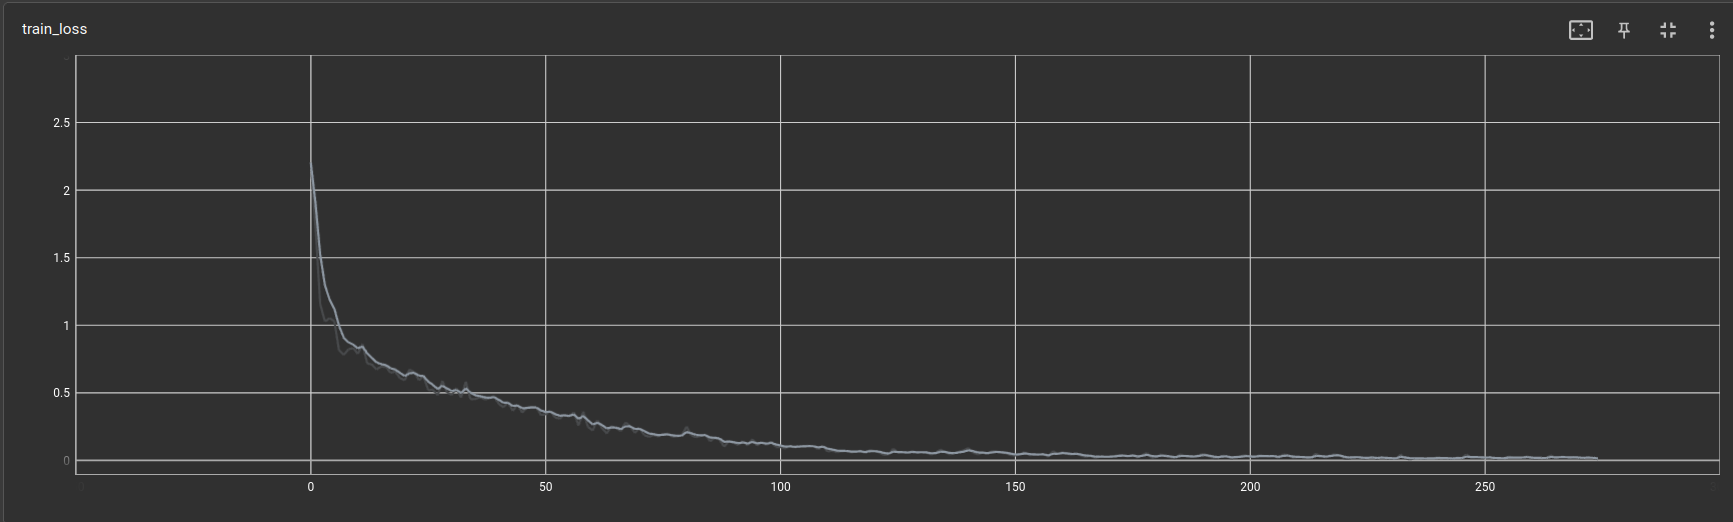

In [1]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_train_loss.png")

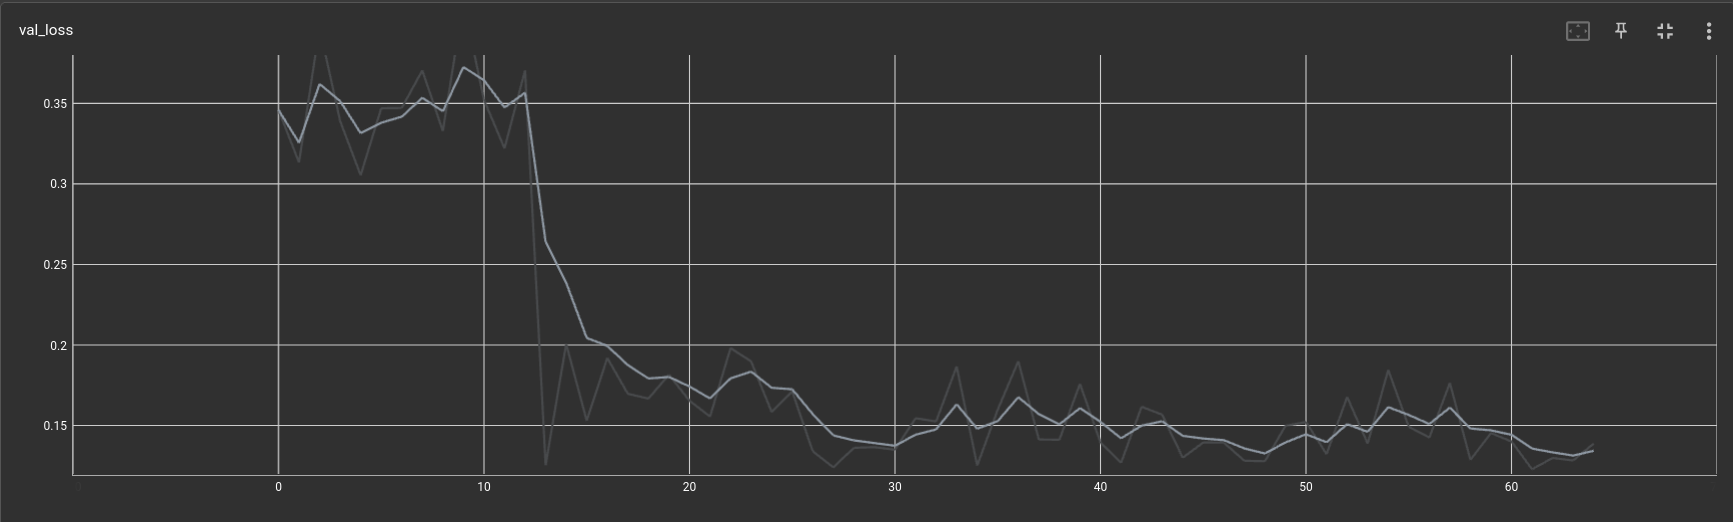

In [2]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_val_loss.png")

### Evaluation

### Metrics

## Part II

### Dataset


### Model

### Trainer

### Training

### Evaluation


### Metrics